In [ ]:
pip install torch torchvision

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib

In [ ]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'CRL_moon_cifar.ipynb', 'Cifar_baseline.ipynb', 'Cifar_baseline_ResNet.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'DAC+Temp_Cifar_dropout_swin.ipynb', 'DAC+Temp_Cifar_mixup_labelsmoothing_swin.ipynb', 'DAC+Temp_Cifar_swin.ipynb', 'Dropout.ipynb', 'Dropout_cifar.ipynb', 'FocalLoss.ipynb', 'FocalLoss_cifar.ipynb', 'LabelSmoothing.ipynb', 'LabelSmoothing_cifar.ipynb', 'Mixup.ipynb', 'Mixup_cifar.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_CRL_cifar.json', 'results_ECE_L

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch
from torchvision.transforms import ToPILImage
import numpy as np
from PIL import Image

# Custom Dataset class to load images on-the-fly
class CIFARC_Dataset(Dataset):
    def __init__(self, data: np.ndarray, labels: list, transform=None):
        assert len(data) == len(labels)
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CIFAR images are in the format (channels, height, width)
        # We need to convert them to (height, width, channels) for PIL
        img = self.data[idx].transpose((1, 2, 0))  # Convert to HxWxC
        img = Image.fromarray(img.astype('uint8'), 'RGB')  # Convert to PIL Image
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

class CombinedCIFARCDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(f"Index out of range: {idx}")

        # Determine which dataset the index falls into
        dataset_idx = np.searchsorted(self.cumulative_lengths, idx, side='right')
        if dataset_idx > 0:
            relative_idx = idx - self.cumulative_lengths[dataset_idx - 1]
        else:
            relative_idx = idx

        return self.datasets[dataset_idx][relative_idx]


# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get the labels from the CIFAR-10 test set
test_labels = full_test_dataset.targets

# Load CIFAR-10-C dataset
file_path = './data/CIFAR-10-C/zoom_blur.npy'  # Make sure this path is correct
cifar_c_data_blur = np.load(file_path)
cifar_c_data_blur = cifar_c_data_blur.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_blur = CIFARC_Dataset(data=cifar_c_data_blur[:500], labels=test_labels[:500], transform=transform)


file_path = './data/CIFAR-10-C/speckle_noise.npy'  # Make sure this path is correct
cifar_c_data_speckle = np.load(file_path)
cifar_c_data_speckle = cifar_c_data_speckle.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_speckle = CIFARC_Dataset(data=cifar_c_data_speckle[:500], labels=test_labels[:500], transform=transform)
# Instantiate the Combined Dataset with blur and speckle datasets
combined_cifar_c_dataset = CombinedCIFARCDataset([cifar_c_dataset_blur, cifar_c_dataset_speckle])
# Define DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_subset, test_subset = random_split(full_test_dataset, [len(full_test_dataset) // 2, len(full_test_dataset) - len(full_test_dataset) // 2])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)
# Define a DataLoader for the combined dataset
OD_loader = DataLoader(combined_cifar_c_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Model loading and overriding
The last fully connected layer of the original model is replaced with a new one containing a dropout layer (for regularization) followed by a linear layer for a binary classification task.
The forward method of this class is overridden to modify the standard forward pass of the ResNet model. Here, the model processes the input through all its layers up to the average pooling layer. The output tensor is then flattened to obtain feature representations (features), and these features are further processed by the fully connected layer (self.fc) to obtain the final output.
The model now returns both the final output and the features.
An instance of the ModifiedResNet model is created using ResNet50's configuration (i.e., using the Bottleneck block and [3, 4, 6, 3] layers, which corresponds to ResNet50). The number of output classes is set to 2, which indicates binary classification.
Again, as with the initial ResNet50 model, the final fully connected layer is replaced with a dropout layer followed by a linear layer

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
model = models.resnet50(pretrained=True)
# Add Dropout and Final Linear Layer to the model's fc
num_classes = 10
model.fc = nn.Sequential(
    nn.Dropout(0.5), # 50% dropout rate
    nn.Linear(model.fc.in_features, num_classes)
)
#This setup means that during training, the dropout layer will randomly zero out (with a probability of 50%)

# If you want to initialize with pretrained weights:
state_dict = models.resnet50(pretrained=True).state_dict()
del state_dict["fc.weight"]
del state_dict["fc.bias"]
model.load_state_dict(state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


_IncompatibleKeys(missing_keys=['fc.1.weight', 'fc.1.bias'], unexpected_keys=[])

This new class aims to modify the provided original_model (in this case, a ResNet model) to not only return the final output (class probabilities) but also the feature representations from the layer before the final fully connected (FC) layer.

The feature extraction part (named self.features) is created by taking all layers from the original_model except the last one (the final FC layer). This is achieved using the list(original_model.children())[:-1] command. The purpose is to get the feature maps before they are flattened and passed through the final FC layer.
The final FC layer (self.fc) is separately stored, as it will be used to produce the final output.

The forward method takes an input tensor x and passes it through the feature extraction layers.
These feature maps are then flattened and passed through the final FC layer to get the model's output.
The function returns both the final output and the feature maps, providing dual functionality: standard prediction and feature extraction.


In [ ]:
pip install tqdm tensorboard

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm  # for a nice progress bar
import matplotlib.pyplot as plt
train_losses = []
val_accuracies = []

# Parameters
num_epochs = 10 # optimal 30 for fsw data
learning_rate = 1e-6

# Using CUDA if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        # Getting outputs and features
        outputs = model(inputs)
        # Use the outputs for loss calculation
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


    # Validation loop with MC Dropout
    num_forward_passes = 10  # Number of forward passes to average over
    model.train()  # Keep dropout active
    val_correct = 0
    val_total = 0
    val_accuracies = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = []

            for _ in range(num_forward_passes):
                outputs = model(inputs)  # Get model outputs
                outputs_list.append(outputs)

            # Average the outputs across the multiple forward passes
            outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)

            # Calculate accuracy based on the averaged outputs
            _, predicted = torch.max(outputs_mean, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy with MC Dropout: {val_accuracy:.2f}%")

print("Finished Training")

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/10] Loss: 2.0161
Validation Accuracy with MC Dropout: 64.48%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/10] Loss: 1.2587
Validation Accuracy with MC Dropout: 79.54%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/10] Loss: 0.7585
Validation Accuracy with MC Dropout: 85.08%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/10] Loss: 0.5126
Validation Accuracy with MC Dropout: 88.28%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/10] Loss: 0.3874
Validation Accuracy with MC Dropout: 89.70%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/10] Loss: 0.3142
Validation Accuracy with MC Dropout: 90.82%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/10] Loss: 0.2645
Validation Accuracy with MC Dropout: 91.48%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/10] Loss: 0.2315
Validation Accuracy with MC Dropout: 92.22%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/10] Loss: 0.2015
Validation Accuracy with MC Dropout: 92.52%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/10] Loss: 0.1793
Validation Accuracy with MC Dropout: 92.90%
Finished Training


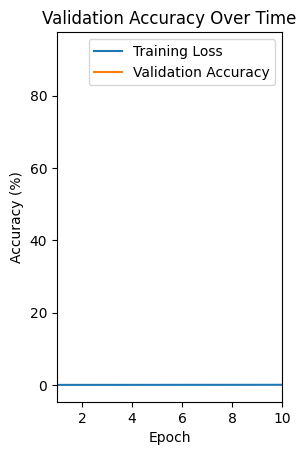

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [ ]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs  = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 91.06%
Average Test Loss: 0.2666


In [ ]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model, OD_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 77.90%
Average Test Loss: 0.6802


MC dropout as Post Hoc calibration

In [ ]:
# Test with dropout calibration
model.train()  # Ensure dropout layers remain active
num_forward_passes=10
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_list = []

        for _ in range(num_forward_passes):
            outputs = model(inputs)
            outputs_list.append(outputs)

        outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)
        _, predicted = outputs_mean.max(1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy_dropout = 100 * correct_test / total_test
print(f"Test Accuracy with Dropout Calibration: {test_accuracy_dropout:.2f}%")

Test Accuracy with Dropout Calibration: 92.58%


In [ ]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.0120


In [ ]:
# Sample test result and current datetime
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_dropout_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities for all classes
        probs = F.softmax(logits, dim=1)

        # Store probabilities and labels
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
correctness = np.array(correctness)
predicted_probs = np.array(predicted_probs)

# Calculate AUROC for each class and average them
auroc = roc_auc_score(correctness, predicted_probs, multi_class='ovr')
print(f"Average AUROC for multi-class: {auroc:.4f}")


Average AUROC for multi-class: 0.9938


In [ ]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc_dropout_cifar.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [ ]:
import torch.nn.functional as F

# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)
ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")


Expected Calibration Error (ECE): 0.0720


In [ ]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD_dropout_cifar.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')